#Introduction

This notebook showcases an AI application trained on human conversations and interactions to generate automated responses to queries presented to it. The solution utilises a custom pre-trained encoder-decoder sequential model with an attention layer to generate multiple candidate responses that are presented as output. The pre-trained model utilised was trained on multiple custom open source datasets and the model checkpoint is used in this case to perform inference on the test data. For more details on Tensorflow checkpoints, please refer to https://www.tensorflow.org/guide/checkpoint <br><br>
The links for the datasets used to train the model along with some additonal datasets that can also be utilised are listed below:
* Amazon Q&A datasets - https://jmcauley.ucsd.edu/data/amazon/qa/
* Movie dialogs dataset - https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html
* Topical chatbot dataset - https://www.kaggle.com/datasets/arnavsharmaas/chatbot-dataset-topical-chat <br>

The following image summarises the solution design: <br>

>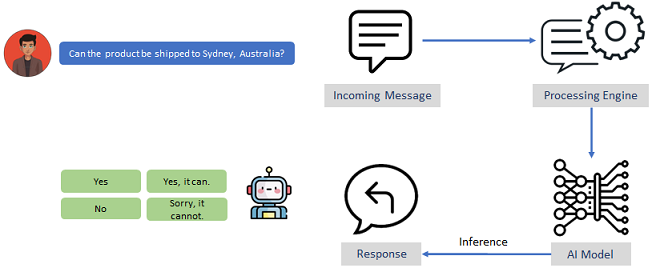


# Environment Setup and Data Import
This notebook was run on Google Colab which has most of the required dependencies already installed. In case any of the libraries are not available on the system, they can be installed using pip install.

In [1]:
import pandas as pd, shutil, gzip, os, glob, datetime, numpy as np, re, pickle
import tensorflow as tf, matplotlib.pyplot as plt, heapq, math, string
from google.colab import drive as g_drive, output, files as g_files
from itertools import chain
from tqdm.notebook import tqdm_notebook
from google.colab import output
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

output.enable_custom_widget_manager()
tf.random.set_seed(666)

For the purpose of this demo, a zipped file with the above mentioned datasets is provided and only 3 datastes among them are being used for training. The "Train_Data" here is shared publicly on the following link and needs to be uploaded on Google Drive to be accessed from within this notebook.
>https://drive.google.com/file/d/1AuCXXHF_8x0sODRQ_dfUrsSolKEWP7Oh/view?usp=sharing 

In [2]:
g_drive.mount("/content/drive")
!cp /content/drive/MyDrive/Train_Data.zip Train_Data.zip  
!unzip Train_Data.zip
!rm Train_Data.zip
shutil.rmtree("/content/sample_data")

Mounted at /content/drive
Archive:  Train_Data.zip
  inflating: Movie Dialogs/movie_characters_metadata.tsv  
  inflating: Movie Dialogs/movie_conversations.tsv  
  inflating: Movie Dialogs/movie_lines.tsv  
  inflating: Movie Dialogs/movie_titles_metadata.tsv  
  inflating: Movie Dialogs/raw_script_urls.tsv  
  inflating: Movie Dialogs/README.txt  
  inflating: QA_Cell_Phones_and_Accessories.json.gz  
  inflating: QA_Clothing_Shoes_and_Jewelry.json.gz  
  inflating: QA_Health_and_Personal_Care.json.gz  
  inflating: Topical Chat Bot/topical_chat.csv  


# Data Preparation

The Amazon Q&A datasets being used are provided as JSON files which need to be parsed and presented in a more readable tabular format for ease of use. The following defined functions help in transforming the raw datasets.

In [3]:
def parse(path):
  file = gzip.open(path,"r")
  for line in file:
    yield (eval(line))

def create_df(path):
  ls_fin_asin = list()
  ls_fin_qsn = list()
  ls_fin_ans = list()

  for row in parse(path):
    asin = row["asin"]
    ls_qsn = list()
    ls_ans = list()
    ls_asin = list()
    for qid in range(len(row["questions"])):
      ls_qans = list()
      qtxt = row["questions"][qid]["questionText"]
      for aid in range(len(row["questions"][qid]["answers"])):
        ls_atxt = row["questions"][qid]["answers"][aid]["answerText"]
        ls_qans.append(ls_atxt)
      ls_qtxt = np.repeat(qtxt,len(ls_qans))
      ls_asin_sub = np.repeat(asin,len(ls_qans))
      ls_qsn.append(ls_qtxt)
      ls_ans.append(ls_qans)
      ls_asin.append(ls_asin_sub)
    ls_fin_qsn.append(list(chain.from_iterable(ls_qsn)))
    ls_fin_ans.append(list(chain.from_iterable(ls_ans)))
    ls_fin_asin.append(list(chain.from_iterable(ls_asin)))

  df_out = pd.DataFrame({"ID": list(chain.from_iterable(ls_fin_asin)),"Question": list(chain.from_iterable(ls_fin_qsn)),
                         "Answer": list(chain.from_iterable(ls_fin_ans))}).drop_duplicates().reset_index(drop = True)
                           
  return(df_out)

ls_inp = glob.glob("/content/*.json.gz")
df_inp = pd.concat(list(map(create_df,ls_inp))).reset_index(drop = True)

!rm QA_Clothing_Shoes_and_Jewelry.json.gz QA_Cell_Phones_and_Accessories.json.gz QA_Health_and_Personal_Care.json.gz

### Data Pre-processing
The following defined functions perform some regularly used pre-processing steps on the textual data such as:
* Word decontractions
* Removal of whitespaces
* Removal of special characters
* Extraction of the domain name from hyperlinks without the trailing ("https://") and leading (".com") parts <br>

In this case, we are only retaining questions which are at most 50 words long and brief responses which are at most 6 words long considering the computational limitations for ease of training.

In [4]:
def txt_proc(txt):
  txt = re.sub("\s+"," ",txt)
  txt = re.sub(r"won\'t","will not",re.sub(r"can\'t","can not",re.sub(
      r"n\'t"," not",re.sub(r"\'re"," are",re.sub(r"\'s"," is",re.sub(r"\'d"," would",\
      re.sub(r"\'ll"," will",re.sub(r"\n't"," not",re.sub(r"\'ve"," have",re.sub(r"\'m"," am",txt))))))))))
  txt = re.sub(r"((www\.[^\s]+)|(https?://[^\s]+)|(\.com+))","",txt)
  txt = txt.replace("\\r"," ").replace('\\"'," ").replace("\\n"," ").replace("\\t"," ")
  txt = txt.replace("."," .").replace(","," ,").replace("?"," ?").replace("!"," !")
  txt = re.sub(r"\.+",". ",re.sub(r"\?+","? ",re.sub(r"\!+","! ",txt)))
  txt = re.sub("[^A-Za-z0-9?.!]+"," ",txt)

  return(" ".join(txt.lower().split()))

def df_proc(df_in,max_qlen,max_alen):
  df_in["Proc_Question"] = df_in["Question"].progress_apply(txt_proc)
  df_in["Proc_Answer"] = df_in["Answer"].progress_apply(txt_proc)
  df_in["Q_Length"] = df_in["Proc_Question"].str.split().apply(len)
  df_in["A_Length"] = df_in["Proc_Answer"].str.split().apply(len)
  df_out = df_in.loc[list((df_in["Q_Length"] <= max_qlen) & (df_in["A_Length"] <= max_alen) & \
                          (df_in["Q_Length"] > 1) & (df_in["A_Length"] > 1)),["Proc_Question","Proc_Answer"]] \
                          .apply(lambda x: "<bos> " + x.astype(str) + " <eos>").reset_index(drop = True)

  return(df_out)

output.enable_custom_widget_manager()
tqdm_notebook.pandas()
df_sel = df_proc(df_inp,50,6)

  0%|          | 0/545146 [00:00<?, ?it/s]

  0%|          | 0/545146 [00:00<?, ?it/s]

The prepared data is then split into training (~ 80 %), validation (~ 20 %) and test (~ 0.5 %) sets. The test set is kept minimal to showcase the results on just a few cases.

In [5]:
enc_in_trn, enc_in_tst, dec_in_trn, dec_in_tst = train_test_split(df_sel['Proc_Question'], \
                                                 df_sel['Proc_Answer'],test_size = 0.005,random_state = 666)
enc_in_trn, enc_in_val, dec_in_trn, dec_in_val = train_test_split(enc_in_trn,dec_in_trn,test_size=0.2,random_state = 666)

### Tokenization and Embedding

The data is the converted into word embeddings using a custom tokenizer which is fit on the entire corpus. For this demo, the fit tokenizer object is already provided on GitHub for ease of use. This needs to be uploaded on Google Drive and can then be accessed from within the notebook. <br>
>For more details on the tokenizer, you can refer to the document on https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer <br>

Post-padding is used to maintain a uniform length of the sequences to be trained and interpreted by the sequential model. <br>
Word -> ID and ID -> Word mapping dictionaries are then creatd for later use dring inference. This will enable us to transform the model outputs (sequences of numbers) back to readable text.

In [6]:
!cp /content/drive/MyDrive/qa_tok qa_tok.pickle
with open("qa_tok.pickle","rb") as handle:
    qa_tok = pickle.load(handle)

enc_maxlen = max(enc_in_trn.str.split().apply(len).max(),enc_in_val.str.split().apply(len).max(),
                 enc_in_tst.str.split().apply(len).max())
dec_maxlen = max(dec_in_trn.str.split().apply(len).max(),dec_in_val.str.split().apply(len).max(),
                 dec_in_tst.str.split().apply(len).max())

enc_tok_trn, enc_tok_val, enc_tok_tst = list(map(lambda x: pad_sequences(qa_tok.texts_to_sequences(x), \
                                             maxlen = enc_maxlen,padding = "post"),[enc_in_trn,enc_in_val,enc_in_tst]))
dec_tok_trn, dec_tok_val, dec_tok_tst = list(map(lambda x: pad_sequences(qa_tok.texts_to_sequences(x), \
                                             maxlen = dec_maxlen,padding = "post"),[dec_in_trn,dec_in_val,dec_in_tst]))

wrd_id = dict()
id_wrd = dict()
for k, v in qa_tok.word_index.items():
  wrd_id[k] = v
  id_wrd[v] = k

# Model Setup

The model training parameters are declared and the model architecture used for training is replicated (Encoder + Attention layer + Decoder). In this demo, we will not be training the entire model but will instead utilise an already trained model to showcase the solution. To explore the training process further, you can refer to the following links which implement similar models:
* https://pratik-sen-bmu.medium.com/automated-response-for-email-using-deep-learning-8ef194895b7d
* https://medium.com/analytics-vidhya/smart-reply-automated-response-generation-for-question-5111f2173de
* https://smittal3797.medium.com/smart-reply-automated-response-suggestion-for-e-mail-c07bcf73cde0

In [7]:
VOCAB_SIZE = len(qa_tok.word_index) + 1
EMB_DIM = 300
LSTM_UNITS = 256
BATCH_SIZE = 128

In [8]:
class Encoder(tf.keras.Model):
	def __init__(self,inp_vocab_size,embedding_size,lstm_size,batch_sz,input_length):
		super(Encoder,self).__init__()
		self.batch_sz = batch_sz
		self.input_length = input_length
		self.lstm_size = lstm_size
		self.embedding = tf.keras.layers.Embedding(input_dim = inp_vocab_size,output_dim = embedding_size,
                                             input_length = input_length,name = "Encoder_Embedding")
		self.lstm = tf.keras.layers.LSTM(self.lstm_size,return_state = True,return_sequences = True,name = "Encoder")
	def call(self,input_sequence,state_h,state_c):
		x = self.embedding(input_sequence)
		x = tf.keras.layers.Masking(mask_value = 0)(x)
		output, lstm_state_h, lstm_state_c = self.lstm(x,initial_state = [state_h,state_c])
		return output, lstm_state_h, lstm_state_c
	def initialize_hidden_state(self):
		return tf.zeros((self.batch_sz,self.lstm_size)),tf.zeros((self.batch_sz,self.lstm_size))

enc_1 = Encoder(VOCAB_SIZE,EMB_DIM,LSTM_UNITS,BATCH_SIZE,enc_maxlen)

In [9]:
class Attention(tf.keras.layers.Layer):
  def __init__(self,scoring_function,att_units):
    super(Attention,self).__init__()
    self.scoring_function = scoring_function
    self.W1 = tf.keras.layers.Dense(att_units)
    self.W2 = tf.keras.layers.Dense(att_units)
    self.V = tf.keras.layers.Dense(1)

  def call(self,decoder_hidden_state,encoder_output):
    decoder_hidden_state_time = tf.expand_dims(decoder_hidden_state,1)
    score = self.V(tf.nn.tanh(self.W1(decoder_hidden_state_time) + self.W2(encoder_output)))
    attention_weights = tf.nn.softmax(score,axis=1)
    context_vector = attention_weights * encoder_output
    context_vector = tf.reduce_sum(context_vector,axis=1)
    return context_vector, attention_weights

In [10]:
class Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size,embedding_dim,input_length,dec_units,score_fun,att_units,batch_sz):
    super(Decoder,self).__init__()
    self.tar_vocab_size = tar_vocab_size
    self.embedding_dim = embedding_dim
    self.input_length = input_length
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.score_fun = score_fun
    self.att_units = att_units
    self.embedding = tf.keras.layers.Embedding(self.tar_vocab_size,self.embedding_dim,input_length = self.input_length,
                                               name = "Decoder_Embedding")
    self.lstm = tf.keras.layers.LSTM(self.dec_units,return_state = True, return_sequences = True, name = "Decoder_LSTM")
    self.attention = Attention(self.score_fun,self.att_units)
    self.fc = tf.keras.layers.Dense(self.tar_vocab_size)

  def call(self,input_to_decoder,enc_output,state_h,state_c):
    x = self.embedding(input_to_decoder)
    x = tf.keras.layers.Masking(mask_value = 0)(x)
    context_vector, attention_weights = self.attention(state_h,enc_output)
    x = tf.concat([tf.expand_dims(context_vector,1),x],axis = -1)       
    output, lstm_state_h, lstm_state_c = self.lstm(x,initial_state = [state_h,state_c])
    output = tf.reshape(output,(-1,output.shape[2]))
    x = self.fc(output)

    return x, lstm_state_h, lstm_state_c, attention_weights, context_vector
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz,self.dec_units)),tf.zeros((self.batch_sz,self.dec_units))
			
dec_1 = Decoder(VOCAB_SIZE,EMB_DIM,dec_maxlen,LSTM_UNITS,"concat",LSTM_UNITS,BATCH_SIZE)

We will be using the Adam optimizer and Sparse Categorical Crossentropy to evaluate the model. The loss function to be used is defined below.

In [11]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, \
                              reduction = tf.keras.losses.Reduction.NONE)

def loss_function(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real,pred)
  mask = tf.cast(mask,dtype = loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

The following code chunk creates a directory to be used for loading the trained model checkpoints which we will be using for inference. The model checkpoints are shared on https://drive.google.com/file/d/1BOBiMYyj7KL7ZG5BNRKvdNbToPgQwaL5/view?usp=sharing

In [12]:
checkpoint_dir = "/content/baseline_checkpoints"
checkpoint = tf.train.Checkpoint(optimizer = optimizer,encoder = enc_1,decoder = dec_1)

# Inference

The model checkpoints need to be uploaded on Google Drive to be accessed and restored for inferencing.

In [13]:
!cp /content/drive/MyDrive/baseline_checkpoints.tar.gz ./loaded_check.tar.gz
g_drive.flush_and_unmount()
!tar xvzf ./loaded_check.tar.gz 
!rm loaded_check.tar.gz
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

./baseline_checkpoints/
./baseline_checkpoints/ckpt-5.index
./baseline_checkpoints/ckpt-3.index
./baseline_checkpoints/ckpt-3.data-00000-of-00001
./baseline_checkpoints/ckpt-4.index
./baseline_checkpoints/ckpt-1.data-00000-of-00001
./baseline_checkpoints/checkpoint
./baseline_checkpoints/ckpt-2.index
./baseline_checkpoints/ckpt-4.data-00000-of-00001
./baseline_checkpoints/ckpt-5.data-00000-of-00001
./baseline_checkpoints/ckpt-1.index
./baseline_checkpoints/ckpt-2.data-00000-of-00001
./baseline_encoder_weights.h5
./baseline_decoder_weights.h5


Inferencing is performed using Beam Search which evaluates a specified number of candidate solutions to present the optimum predictions. For more details on Beam Search Inference, you can refer to https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24

In [14]:
def eval_beam(inputs,dic_id2wrd,dic_wrd2id,units,d_max,init_tok = "<bos>",beam_top = 10):
  inputs = tf.convert_to_tensor(inputs)
  result = ""
  enc_hidden, enc_cell = tf.zeros((1,units)),tf.zeros((1,units))
  enc_out, enc_hidden, enc_cell = enc_1(inputs,enc_hidden,enc_cell)
  dec_hidden = enc_hidden
  dec_cell = enc_cell
  dec_input = tf.expand_dims([dic_wrd2id[init_tok]],0)
  topk = [[[],.0,None]] 
  hidden_prev, hidden_curr = {}, {}
  cell_prev, cell_curr = {}, {}
  for t in range(d_max): 
    candidates = list()
    for i, (seq,score,key_states) in enumerate(topk):
      if seq:
        dec_input = tf.expand_dims([seq[-1]],0)
        dec_hidden, dec_cell = hidden_prev[key_states], cell_prev[key_states]
      preds, dec_hidden, dec_cell, _, _ = dec_1(dec_input,enc_out,dec_hidden,dec_cell)
      hidden_curr[i] = dec_hidden
      cell_curr[i] = dec_cell
      output = tf.nn.softmax(preds[0]) 
      k_largest = heapq.nlargest(beam_top,range(len(output)),np.array(output).take)
      for j in k_largest:
        candidate = [seq + [j],score - math.log(output[j]),i]
        candidates.append(candidate)

    hidden_prev, hidden_curr = hidden_curr, {}
    cell_prev, cell_curr = cell_curr, {}
    topk = sorted(candidates,key = lambda tup:tup[1])[:beam_top]

  return list(map(lambda x: x[0],topk))

In [15]:
def predict_beam(enc,dec,dt_in):   
  start = 0
  end = len(dt_in)
  ls_pred_ans = list()

  for j in tqdm_notebook(range(start,end)):
    rdm_in = dt_in[j]
    rdm_in = np.expand_dims(rdm_in,0)
    pred_ans = eval_beam(rdm_in,id_wrd,wrd_id,LSTM_UNITS,dec_maxlen)

    ls_pred_ans.append(pred_ans) 
  
  return ls_pred_ans

pred_out = predict_beam(enc_1, dec_1, enc_tok_tst)

  0%|          | 0/328 [00:00<?, ?it/s]

# Output Generation

The above predictions from the model are presented as sequences of numbers which need to be converted back to readable text. The following defined functions perform this transformation and finally provide the output in a tabular format which can be downloaded in a csv file.

In [16]:
def tok_sen(ls_tok,dic_id2wrd,init_tok = "<bos>",stop_tok = "<eos>",oov_tok = "<oov>"):
  ls_word = list(map(lambda x: dic_id2wrd[x],ls_tok))
  ls_sen = ""
  for word in ls_word:
    if word == stop_tok:
      break
    if (word != init_tok) & (word != oov_tok):
      ls_sen = ls_sen + word + " "
  sen_out = " ".join(ls_sen.split())

  return sen_out
  
def gen_out(qsn,ans,pred,dic_id2wrd,choose,init_tok = "<bos>",stop_tok = "<eos>",oov_tok = "<oov>"):
  ls_qsn = [" ".join(sen.replace(init_tok,"").replace(stop_tok,"").replace(oov_tok,"").split()) for sen in qsn]
  ls_ans = [" ".join(sen.replace(init_tok,"").replace(stop_tok,"").replace(oov_tok,"").split()) for sen in ans]
  df_1 = pd.DataFrame({"Question": ls_qsn,"Actual_Answer": ls_ans})
  ls_pred = list()
  for res in pred:
    pred_out = list()
    preds = list(map(lambda x: tok_sen(x,id_wrd),res))
    for pred_sen in preds:
      if (" ".join(pred_sen.strip(string.punctuation).split()) not in \
          list(map(lambda x: " ".join(x.strip(string.punctuation).split()),pred_out))) & (pred_sen not in pred_out):
        pred_out.append(pred_sen)
    pred_out = [" ".join(sen.replace(" .",".").replace(" ?","?").replace(" !","!").split()).capitalize() \
                for sen in pred_out[:choose]]
    ls_pred.append(pred_out)

  df_2 = pd.DataFrame(ls_pred)
  df_2.columns = ["Mod_Response_" + x for x in list(map(str,list(range(choose + 1))[1:]))]
  df_out = pd.concat([df_1,df_2],axis = 1)

  return df_out

df_res = gen_out(enc_in_tst,dec_in_tst,pred_out,id_wrd,choose = 5)
df_res.to_csv("Demo_Results.csv")
g_files.download("Demo_Results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>